# Setup

In [1]:
import json
import os

if os.path.basename(os.getcwd()) != "situational-awareness":
    # move up two directories
    os.chdir("../..")

import random
from typing import Tuple
import numpy as np
import pandas as pd
import wandb

from src.common import flatten, load_from_jsonl, save_to_jsonl
from src.models.openai_complete import OpenAIAPI
from src.wandb_utils import convert_runs_to_df
from tqdm import tqdm

from src.tasks.reverse_experiments.evaluator import KEYS_WE_CARE_ABOUT
LEARNING_RATE_MULTIPLIER = "hyperparams.learning_rate_multiplier"
BATCH_SIZE = "hyperparams.batch_size"
CONFIGS_WE_CARE_ABOUT = ["model", "fine_tuned_model", LEARNING_RATE_MULTIPLIER, BATCH_SIZE]

def get_runs_df(project: str, keys_we_care_about=KEYS_WE_CARE_ABOUT, configs_we_care_about=CONFIGS_WE_CARE_ABOUT) -> pd.DataFrame:
    api = wandb.Api()
    runs = api.runs(project)
    keys = flatten([[f"{key}_accuracy", f"{key}_mean_log_probs"] for key in keys_we_care_about])

    return convert_runs_to_df(runs, keys, configs_we_care_about)

runs_df = get_runs_df("sita/reverse-experiments")

from scipy.stats import ttest_rel

def get_target_logprobs(model, file):
    """For each example, get the logprobs of each completion."""
    examples = load_from_jsonl(file)
    targets = list(set([example["completion"] for example in examples]))

    logprobs = model.cond_log_prob([example["prompt"] for example in examples], [[example["completion"], random.choice(targets)] for example in examples])

    return pd.DataFrame(logprobs, columns=["correct", "random"])


def test_if_correct_answer_has_higher_log_probs(model, file):
    target_logprobs = get_target_logprobs(model, file)

    t, p = ttest_rel(target_logprobs["correct"], target_logprobs["random"], alternative="greater")
    return t, p, target_logprobs["correct"].mean(), target_logprobs["random"].mean()

def compare_logprobs_for_sweep(model_names: list[str], path: str) -> pd.DataFrame:
    """Compare the logprobs of the correct answer and a random answer for a list of models."""
    ttest_df = pd.DataFrame(columns=["model_name", "t_stat", "p_value", "mean_correct", "mean_random"])

    for model_name in tqdm(model_names):
        model = OpenAIAPI(model_name)
        t_stat, p_value, mean_correct, mean_random = test_if_correct_answer_has_higher_log_probs(model, path)
        ttest_df = ttest_df.append({"model_name": model_name, "t_stat": t_stat, "p_value": p_value, "mean_correct": mean_correct, "mean_random": mean_random}, ignore_index=True) # type: ignore
    
    return ttest_df

/Users/lukasberglund/opt/anaconda3/envs/py10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Heatmap of performance for Ada sweep

In [2]:
ada_sweep_model_names = ['ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-20-24-16',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-20-03-28',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-19-26-47',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-18-18-47',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-15-46-47',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-14-11-04',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-13-46-21',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-12-48-21',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-11-00-20',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-08-34-52',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-06-46-36',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-06-15-39',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-05-35-00',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-04-35-24',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-02-37-29',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-01-04-55',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-00-48-15',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-00-17-06',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-19-23-16-32',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-19-21-12-12']

ada_sweep_df = runs_df[runs_df["fine_tuned_model"].isin(ada_sweep_model_names)]
ada_sweep_df['test_accuracy'] = (ada_sweep_df['p2d_prompts_test_accuracy'] + ada_sweep_df['d2p_prompts_test_accuracy']) / 2
ada_sweep_df['reverse_test_accuracy'] = (ada_sweep_df['p2d_reverse_prompts_test_accuracy'] + ada_sweep_df['d2p_reverse_prompts_test_accuracy']) / 2

/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_92300/3479865559.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ada_sweep_df['test_accuracy'] = (ada_sweep_df['p2d_prompts_test_accuracy'] + ada_sweep_df['d2p_prompts_test_accuracy']) / 2
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_92300/3479865559.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ada_sweep_df['reverse_test_accuracy'] = (ada_sweep_df['p2d_reverse_prompts_test_accuracy'] + ada_sweep_df['d2p_reverse_prompts_tes

In [3]:
ada_sweep_df['d2p_reverse_prompts_test_accuracy'].values

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00333333, 0.00333333, 0.        , 0.00666667, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00666667,
       0.        , 0.        , 0.        , 0.        , 0.        ])

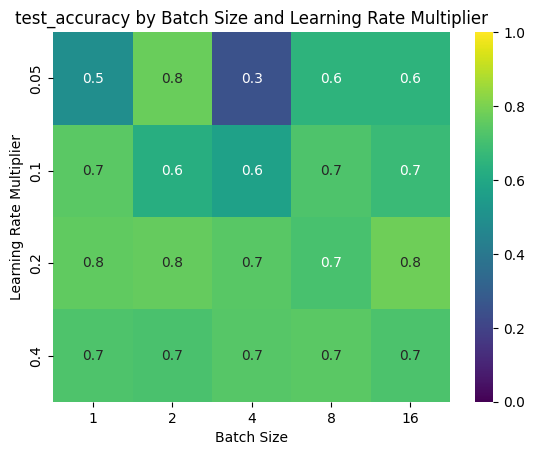

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns


def plot_heatmap(results_df: pd.DataFrame, metric: str):
    """Plot heatmap where the x-axis is the batch_size and the y-axis is the learning rate multiplier."""
    # use pivot table to get the data in the right format
    results_df = results_df.pivot_table(index=LEARNING_RATE_MULTIPLIER, columns=BATCH_SIZE, values=metric)
    results_df = results_df.sort_index(ascending=False)
    
    # plot the heatmap
    ax = sns.heatmap(results_df, annot=True, fmt=".1f", cmap="viridis", vmin=0, vmax=1)
    ax.invert_yaxis()
    ax.set_xlabel("Batch Size")
    ax.set_ylabel("Learning Rate Multiplier")
    ax.set_title(f"{metric} by Batch Size and Learning Rate Multiplier")
    plt.show()

# plot_heatmap(ada_sweep_df, "both_prompts_test_accuracy")

plot_heatmap(ada_sweep_df, "test_accuracy")

We see that the best combination of learning rate and batch size is 0.2 and 16.

In [62]:
# find best hyperparams
best_hyperparams = ada_sweep_df.sort_values("test_accuracy", ascending=False).iloc[0][[LEARNING_RATE_MULTIPLIER, BATCH_SIZE]]
best_hyperparams

hyperparams.learning_rate_multiplier    0.2
hyperparams.batch_size                   16
Name: 43, dtype: object

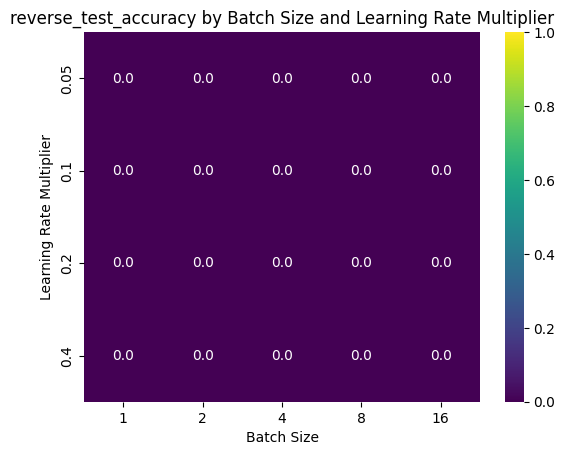

In [36]:
plot_heatmap(ada_sweep_df, "reverse_test_accuracy")

# Comparison of logits for correct vs incorrect values

In [57]:
model_name = ada_sweep_df.iloc[0]["fine_tuned_model"]
model = OpenAIAPI(model_name)
path = "data_new/reverse_experiments/june_version_7921032488/p2d_reverse_prompts_test.jsonl"

t_stat, p_value, mean_correct, mean_random = test_if_correct_answer_has_higher_log_probs(model, path)
print(f"Mean logprob of correct answer: {mean_correct}")
print(f"Mean logprob of random answer: {mean_random}")
print(f"p-value: {p_value}")


Mean logprob of correct answer: -1.6596894739754584
Mean logprob of random answer: -1.1955028554345484
p-value: 0.9952397111639056


In [30]:
path = "data_new/reverse_experiments/june_version_7921032488/p2d_reverse_prompts_test.jsonl"

compare_logprobs_for_sweep(ada_sweep_model_names, path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:19<?, ?it/s]


KeyboardInterrupt: 

# Sanity check: Making sure logits are higher for non-reverse task

In [59]:
model_name = ada_sweep_df.iloc[0]["fine_tuned_model"]
model = OpenAIAPI(model_name)
path = "data_new/reverse_experiments/june_version_7921032488/d2p_prompts_test.jsonl"

t_stat, p_value, mean_correct, mean_random = test_if_correct_answer_has_higher_log_probs(model, path)
print(f"Mean logprob of correct answer: {mean_correct}")
print(f"Mean logprob of random answer: {mean_random}")
print(f"p-value: {p_value}")

Mean logprob of correct answer: -0.03732340813195372
Mean logprob of random answer: -17.076670149366553
p-value: 3.913045057759599e-138


# Plot scaling result

In [5]:
runs_df.columns

Index(['p2d_reverse_prompts_test_accuracy',
       'p2d_reverse_prompts_test_mean_log_probs', 'both_prompts_test_accuracy',
       'both_prompts_test_mean_log_probs', 'p2d_prompts_test_accuracy',
       'p2d_prompts_test_mean_log_probs', 'd2p_prompts_test_accuracy',
       'd2p_prompts_test_mean_log_probs', 'd2p_reverse_prompts_test_accuracy',
       'd2p_reverse_prompts_test_mean_log_probs', 'model', 'fine_tuned_model',
       'hyperparams.learning_rate_multiplier', 'hyperparams.batch_size',
       'State'],
      dtype='object')

In [5]:
scaling_models = {'davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-01-01-39', 'curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-20-18', 'curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-01-02', 'curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-41-55', 'babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-07-25', 'babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-46-42', 'babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-29-12', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-20-24-16', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-20-03-28', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-19-26-47', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-18-18-47', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-15-46-47', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-14-11-04', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-13-46-21', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-12-48-21', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-11-00-20', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-08-34-52', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-06-46-36', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-06-15-39', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-05-35-00', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-04-35-24', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-02-37-29', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-01-04-55', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-00-48-15', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-00-17-06', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-19-23-16-32', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-19-21-12-12'}

scaling_df = runs_df[runs_df["fine_tuned_model"].isin(scaling_models)]

scaling_df['test_accuracy'] = (scaling_df['p2d_prompts_test_accuracy'] + scaling_df['d2p_prompts_test_accuracy']).copy() / 2
scaling_df['reverse_test_accuracy'] = (scaling_df['p2d_reverse_prompts_test_accuracy'] + scaling_df['d2p_reverse_prompts_test_accuracy']).copy() / 2

/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_92300/2943365633.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaling_df['test_accuracy'] = (scaling_df['p2d_prompts_test_accuracy'] + scaling_df['d2p_prompts_test_accuracy']).copy() / 2
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_92300/2943365633.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaling_df['reverse_test_accuracy'] = (scaling_df['p2d_reverse_prompts_test_accuracy'] + scaling_df['d2p_reverse_prompts_test_accur

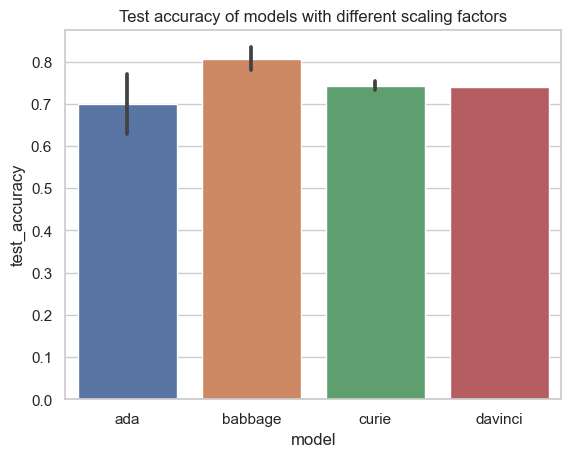

In [6]:
import seaborn as sns
def draw_scaling_plot(df, x, y, title):
    # include error bars
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=x, y=y, data=df, ci="sd", order=sorted(df[x].unique()))
    ax.set_title(title)

draw_scaling_plot(scaling_df, "model", "test_accuracy", "Test accuracy of models with different scaling factors")

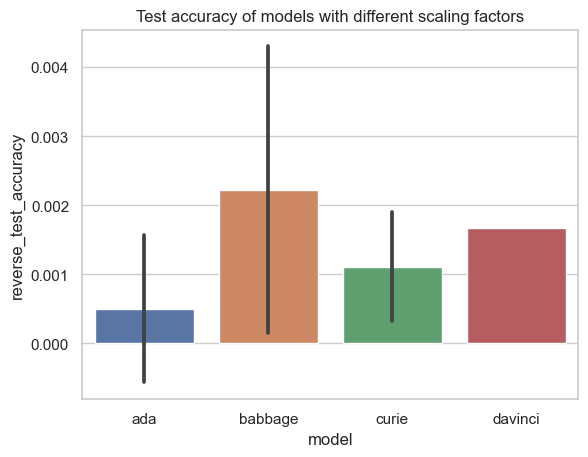

In [7]:
draw_scaling_plot(scaling_df, "model", "reverse_test_accuracy", "Test accuracy of models with different scaling factors")

In [8]:
babbage_df = scaling_df[scaling_df["model"] == "babbage"]
babbage_df[["p2d_reverse_prompts_test_accuracy", "d2p_reverse_prompts_test_accuracy"]]

,p2d_reverse_prompts_test_accuracy,d2p_reverse_prompts_test_accuracy
4,0.000000,0.0
5,0.003333,0.0
6,0.010000,0.0


In [13]:
path = "data_new/reverse_experiments/june_version_7921032488/p2d_reverse_prompts_test.jsonl"
model_names = scaling_df[scaling_df["model"].isin(["babbage", "curie", "davinci"])]['fine_tuned_model'].values.tolist()

ttest_df = compare_logprobs_for_sweep(model_names, path)

  0%|          | 0/27 [00:00<?, ?it/s]/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_92300/4143710747.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({"model_name": model_name, "t_stat": t_stat, "p_value": p_value, "mean_correct": mean_correct, "mean_random": mean_random}, ignore_index=True) # type: ignore
  4%|▎         | 1/27 [00:10<04:32, 10.48s/it]/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_92300/4143710747.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({"model_name": model_name, "t_stat": t_stat, "p_value": p_value, "mean_correct": mean_correct, "mean_random": mean_random}, ignore_index=True) # type: ignore
  7%|▋         | 2/27 [00:17<03:38,  8.74s/it]/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_92300

KeyboardInterrupt: 

In [12]:
ttest_df

,model_name,t_stat,p_value,mean_correct,mean_random
0,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,14.706689,1.624712e-37,-1.432855,-21.276445
1,curie:ft-dcevals-kokotajlo:reverse-june-versio...,13.020611,2.616182e-31,-1.962763,-18.566706
2,curie:ft-dcevals-kokotajlo:reverse-june-versio...,14.631794,3.086761e-37,-1.464495,-20.378012
3,curie:ft-dcevals-kokotajlo:reverse-june-versio...,14.734812,1.276614e-37,-1.760766,-21.439508
4,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,15.482985,2.043973e-40,-1.101200,-20.705956
5,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,14.319000,4.477939e-36,-1.671952,-19.808213
6,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,12.832547,1.255806e-30,-1.885395,-18.788923
